# Implementació de la xarxa neuronal ERFNet MA per a la segmentació de grapes (entrenament amb 60 èpoques)

Carregarem els paquets necessaris

In [1]:
import cv2
import glob
import numpy 
import os
import skimage

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from matplotlib import pyplot as plt
from numpy.random import seed
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend 
from tensorflow.keras.optimizers import *
from typing import Tuple, List

os.environ["CUDA_VISIBLE_DEVICES"]="1"
seed(1)

2024-07-01 21:39:29.224013: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Lectura del *Redscar Dataset* i implementació del generador

Les imatges que s'empraran per a fer l'entrenament les anirem carregant a mesura que la xarxa les demani, per evitar carregar tot el dataset en memòria. Primer de tot, establirem la ruta del dataset.

In [2]:
REDSCAR_DATASET = "/home/marc/UIB_EXPERIMENTS/REDSCAR"
REDSCAR_DATASET_TRAIN = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "train")
REDSCAR_DATASET_TEST = os.path.join(REDSCAR_DATASET, "SUBSETS", "MACHINE_LEARNING_DATASET", "test")

In [3]:
def neural_network_generator(img_path: str, gt_path: str, size: Tuple[int, int], batch_size: int):
    images = sorted(glob.glob(img_path))
    masks = sorted(glob.glob(gt_path))
    
    assert len(images) == len(masks), "The number of images and masks to be used must match."
    
    batch_img = []
    batch_mask = []
    idx = 1
    
    while(True):
        path_img = images[idx % len(images)]
        path_mask = masks[idx % len(images)]
    
        img = cv2.imread(path_img, 1)
        mask = cv2.imread(path_mask, 0)
        
        img = skimage.transform.resize(img, (size[0], size[1], 3))
        mask = cv2.resize(mask, size)
        
        mask = mask/255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
            
        batch_img.append(img)
        
        mask_original = mask
        mask_invertida = 1-mask_original
        
        batch_mask.append(numpy.dstack([mask_original, mask_invertida]))
        
        if (idx%(batch_size) == 0) and idx != 0:            
            batch_img = numpy.array(batch_img)
            batch_mask = numpy.array(batch_mask)
            
            yield batch_img, batch_mask
            
            batch_img = []
            batch_mask = []
        idx += 1
        
def validation_generator(img_path: str, gt_path: str, size: Tuple[int, int]):
    images_names = sorted(glob.glob(img_path))
    masks_names = sorted(glob.glob(gt_path))
    
    images = []
    masks = []
    
    for image_idx in range(len(images_names)):
        path_img = images_names[image_idx]
        path_mask = masks_names[image_idx]
    
        img = cv2.imread(path_img, 1)
        mask = cv2.imread(path_mask, 0)
        
        img = skimage.transform.resize(img, (size[0], size[1], 3))
        mask = cv2.resize(mask, size)
        
        mask = mask/255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
        
        images.append(img)
        
        mask_original = mask
        mask_invertida = 1-mask_original
        
        masks.append(numpy.dstack([mask_original, mask_invertida]))
        
    return (numpy.array(images), numpy.array(masks))

In [4]:
IMAGES_TEST, GT_TEST = validation_generator(img_path=REDSCAR_DATASET_TEST+'/IMAGES/*.png', 
                       gt_path=REDSCAR_DATASET_TEST+'/GT_STAPLES_MASK/*.png', 
                       size=(512, 512))

In [5]:
# BATCH_SIZE = 5
# for image_batch, mask_batch in neural_network_generator(img_path=REDSCAR_DATASET_TRAIN+'/IMAGES/*.png', 
#                                                         gt_path=REDSCAR_DATASET_TRAIN+'/GT_WOUND_MASK/*.png', 
#                                                         size=(256, 256), 
#                                                         batch_size=BATCH_SIZE):
#     print(image_batch.shape, mask_batch.shape)
#     for i in range(0, BATCH_SIZE):
#         plt.imshow(image_batch[i,:,:,:])
#         plt.show()
#         plt.imshow(mask_batch[i,:,:])
#         plt.show()
#     break

## Implementació de la ERFNet

L'arquitectura ERFNet es va proposar per primera vegada a *Erfnet: Efficient residual
factorized convnet for real-time semantic segmentation*. És una xarxa del tipus codificador-decodificador, i es va proposar per a realitzar segmentació semàntica en temps real.

El que farem serà implementar una funció per als blocs de codificació (els de l'esquerra), i una funció per als blocs de decodificació (els de la dreta). A més, la pecularietat d'aquesta xarxa és que introdueix un conjunt de capes anomenades *non-bottleneck-1D*. També contenen un bloc anomenat *downsampler* usat al codificador.

In [6]:
def non_bottleneck_1d(inputs, num_filters, d):
    # convolució de nucli 3x1, sense reducció de la dimensionalitat + capa d'activació ReLU
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3,1), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    # convolució de nucli 1x3, sense reducció de la dimensionalitat, + ReLU
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(1,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    # BN
    x = tf.keras.layers.BatchNormalization()(x)
    
    # convolució dilatada de nucli 3x1, tassa de dil·latació fixada (d,1) + ReLU
    x = tf.keras.layers.Conv2D(filters=num_filters,kernel_size=(3,1),padding='same',dilation_rate=(d, 1),activation='relu',kernel_initializer='he_normal')(x)
    # convolució dilatada de nucli 1x3, tassa de dil·latació fixada (1,d) 
    x = tf.keras.layers.Conv2D(filters=num_filters,kernel_size=(1,3),padding='same',dilation_rate=(1, d),activation='relu',kernel_initializer='he_normal')(x)
    # BN
    x = tf.keras.layers.BatchNormalization()(x)
    
    # dropout amb taxa de 0.3
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    
    # sumam a la sortida de N-NB-1D l'entrada
    y = tf.keras.layers.Add()([x,inputs]) 
    # capa d'activació ReLU
    y = tf.keras.layers.ReLU()(y)
    # augment de la dimensionalitat: Conv. Transposta amb activació SoftMax
    # y = upsampler(y,num_filters,'relu')
    
    return y

In [7]:
def downsampler(inputs, num_filters_entrada,num_filters_sortida):
    # 3 × 3 convolution with stride 2 -> x
    x = tf.keras.layers.Conv2D(filters=num_filters_sortida-num_filters_entrada,kernel_size=(3,3),strides=2,padding='same')(inputs)
    
    # Max-Pooling -> y
    y = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(inputs)
    
    # concatenation of x and y
    concatenacio = tf.keras.layers.concatenate([x,y])
    
    concatenacio = tf.keras.layers.BatchNormalization()(concatenacio)
    
    concatenacio = tf.keras.layers.ReLU()(concatenacio)
    return concatenacio

In [8]:
def upsampler(inputs, num_filters, funcio_activacio,k):
    # augment de la dimensionalitat: Conv. Transposta amb activació SoftMax
    x = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=k, padding = 'same', kernel_initializer = 'he_normal', strides = 2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(funcio_activacio)(x)
    return x

In [9]:
def encoder_block(inputs): 
    # reducció de la dimensionalitat
    x = downsampler(inputs, 3, 16)
    # reducció de la dimensionalitat
    x = downsampler(x, 16, 64)
    
    # 5x N-B-1d 
    for _ in range(5):
        x = non_bottleneck_1d(x, 64, 1)
    
    # reducció de la dimensionalitat
    x = downsampler(x, 64,128)
    
    ds = [2,4,8,16,2,4,8,16]
    for d in ds:
        x = non_bottleneck_1d(x, 128, d)

    return x


def decoder_block(inputs): 
    # augment de la dimensionalitat
    x = upsampler(inputs, 64, 'relu',3)
    # 2x N-B-1d amb d=1
    for _ in range(2):
        x = non_bottleneck_1d(x, 64, 1)
    
    # augment de la dimensionalitat
    x = upsampler(x, 16, 'relu',3)
    # 2x N-B-1d amb d=1
    for _ in range(2):
        x = non_bottleneck_1d(x, 16, 1)
    
    # augment de la dimensionalitat
    x = upsampler(x, 2, 'softmax', 2)
    return x

In [10]:
def build_erfnet(input_shape=Tuple[int,int,int]):
    inputs = tf.keras.layers.Input(input_shape)
    
    x = encoder_block(inputs)
    outputs = decoder_block(x)
    
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs, name = 'ERF-Net2') 
    return model

In [11]:
erfnet = build_erfnet(input_shape=(512, 512, 3)) 
erfnet.summary()

2024-04-15 17:20:58.911495: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-04-15 17:20:58.920945: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-15 17:20:58.921001: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: T-Series
2024-04-15 17:20:58.921028: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: T-Series
2024-04-15 17:20:58.921143: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.33.1
2024-04-15 17:20:58.921197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.33.1
2024-04-15 17:20:58.921210: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.33.1
2024-04-15 17:20:58.921609: I tensorflow/core/platform/cpu_feature

Model: "ERF-Net2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 16) 0           conv2d[0][0]                     
                                                                 max_pooling2d[0][0]       

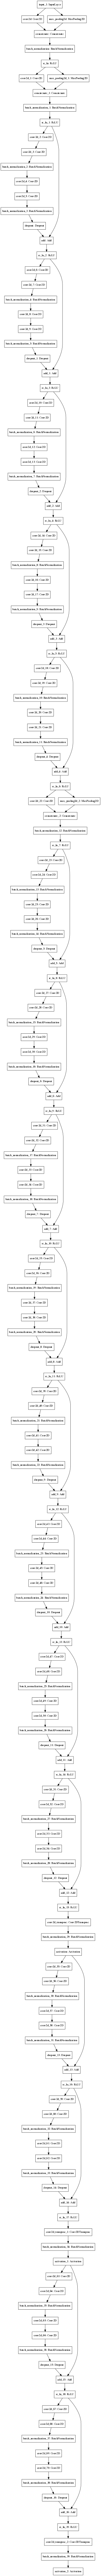

In [12]:
tf.keras.utils.plot_model(
    erfnet,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=46,
)

## Entrenament de la ERFNet:


Ja ho tenim quasi a punt per a fer l'entrenament. Només ens queda definir la funció de pèrdua. Emprarem el coeficient de dice atès que és una mètrica emprada usualment en aquests casos.

In [3]:
def dice(y_true, y_pred):
    y_true_f = backend.flatten(y_true)
    y_pred_f = backend.flatten(y_pred)
    intersection = backend.sum(y_true_f * y_pred_f)
    return (2.* intersection+1) / (backend.sum(y_true_f) + backend.sum(y_pred_f)+1 )

def dice_loss(y_true, y_pred):
    return 1-dice(y_true, y_pred)

In [14]:
erfnet.compile(optimizer=Adam(learning_rate = 3e-4), loss=dice_loss, metrics = [dice])

In [15]:
BATCH_SIZE = 5
TOTAL_IMAGES = 275
STEPS_PER_EPOCH = TOTAL_IMAGES // BATCH_SIZE 
EPOCHS = 60

reduceLROnPlat = ReduceLROnPlateau(monitor='dice', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', cooldown=2, min_lr=1e-7)
early = EarlyStopping(monitor="dice",
                      mode="max",
                      patience=8)
CALLBACKS = [early, reduceLROnPlat]

TRAIN_GENERATOR = neural_network_generator(img_path=REDSCAR_DATASET_TRAIN+'/IMAGES/*.png', 
                                           gt_path=REDSCAR_DATASET_TRAIN+'/GT_STAPLES_MASK/*.png', 
                                           size=(512, 512), 
                                           batch_size=BATCH_SIZE)

In [16]:
training_history = erfnet.fit(TRAIN_GENERATOR, 
                            validation_data=(IMAGES_TEST, GT_TEST),
                            epochs=EPOCHS,
                            validation_steps=2,
                            callbacks=CALLBACKS,
                            steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/60
55/55 [==============================] - 330s 6s/step - loss: 0.4555 - dice: 0.5445 - val_loss: 0.4187 - val_dice: 0.5813
Epoch 2/60
55/55 [==============================] - 340s 6s/step - loss: 0.4240 - dice: 0.5760 - val_loss: 0.3676 - val_dice: 0.6324
Epoch 3/60
55/55 [==============================] - 332s 6s/step - loss: 0.4037 - dice: 0.5963 - val_loss: 0.3348 - val_dice: 0.6652
Epoch 4/60
55/55 [==============================] - 329s 6s/step - loss: 0.3897 - dice: 0.6103 - val_loss: 0.3118 - val_dice: 0.6882
Epoch 5/60
55/55 [==============================] - 329s 6s/step - loss: 0.3791 - dice: 0.6209 - val_loss: 0.2953 - val_dice: 0.7047
Epoch 6/60
55/55 [==============================] - 329s 6s/step - loss: 0.3696 - dice: 0.6304 - val_loss: 0.2821 - val_dice: 0.7179
Epoch 7/60
55/55 [==============================] - 329s 6s/step - loss: 0.3605 - dice: 0.6395 - val_loss: 0.2699 - val_dice: 0.7301
Epoch 8/60
55/55 [==============================] - 330s 6s/step - lo

No basta només amb entrenar la xarxa. També hem de poder avaluar la qualitat de l'entrenament. Per això, la variable `training_history` de la cel·la anterior té aquesta informació.

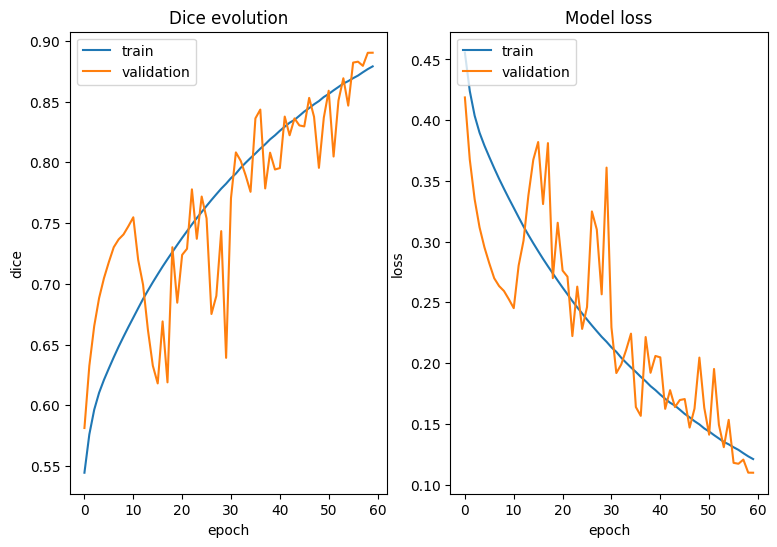

In [17]:
plt.figure(figsize=(9,6), dpi= 100, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.plot(training_history.history['dice'])
plt.plot(training_history.history['val_dice'])
plt.title('Dice evolution')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20'
plt.savefig(EXPERIMENT_PATH+f'/erfnet_ma_grapes_rendiment.png')

**Molt important també**. Podem haver fet l'entrenament, però si en algun moment volem fer una altra prova naturalment tornar a entrenar la xarxa no és una opció, perquè perdem temps de computació en una feina que prèviament ja hem fet. Per això, podem guardar el model en un fitxer, i recuperar-lo posteriorment per a fer les prediccions que puguin fer falta. L'extensió del fitxer **sempre** ha de ser `.h5`.

In [18]:
erfnet.save(os.path.join(EXPERIMENT_PATH, "erfnet_ma_grapes.h5"))

Si ara volem recuperar el model, ho farem de la següent manera. L'estat de la xarxa és idèndic a quan la vàrem guardar.

In [4]:
EXPERIMENT_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20'
from tensorflow.keras.models import load_model
loaded_model = load_model(os.path.join(EXPERIMENT_PATH, "erfnet_ma_grapes.h5"), 
                          custom_objects={'dice_loss': dice_loss, 'dice': dice})

2024-07-01 21:39:40.610212: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-07-01 21:39:40.631590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2024-07-01 21:39:40.631628: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2024-07-01 21:39:40.633170: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-07-01 21:39:40.634507: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2024-07-01 21:39:40.634738: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

## Prediccions amb la ERFNet 

Fins ara hem implementat la ERFNet, l'hem entrenat i hem guardat els pesos a un fitxer per a poder fer futures prediccions. Això és el que pretenem fer en aquesta secció: passar-li una imatge a la ERFNet, i que ens faci la predicció. 

És important observar un fet: quan li passam imatges amb el generador, li estem donant amb una certa mida, i la xarxa ens torna les imatges també amb una certa mida de sortida. Però clar, no totes les imatges del dataset tenen la mateixa mida, ni tampoc tenen la mateixa mida $256\times 256$ que li imposam a la xarxa. Per aquest motiu, és important establir un criteri. Com que les màscares ens determinen la posició exacta de l'objecte, farem el següent:

1. Donada una imatge sobre la que volem fer la predicció, canviar la seva mida a la dimensió d'entrada de la xarxa.
2. Calcular la predicció del model, que ens tornarà una imatge en la dimensió de sortida del mateix. Aquesta sortida serà, **en el cas de la ERFNet**, una imatge amb entrades dins l'interval $[0,1]$, que podem interpretar com una imatge en escala de grisos.
3. Redimensionar aquesta sortida amb les dimensions de la imatge en qüestió.
4. Binaritzar el resultat de la passa anterior.
5. Comparar amb la màscara.

Un dubte que pot sorgir és si les passes 3 i 4 es poden permutar. La resposta és que no. Si primer binaritzam, quan facem el canvi d'escala posterior la imatge resultant **no** és, en general, binària. Hem de pensar que fer un canvi d'escala aplica per darrere una sèrie de tècniques d'interpolació, que poden donar lloc a imatges en escala de grisos, que no són comparables a la passa 4 amb la màscara final.

In [5]:
def predict_image(model: tf.keras.models.Model, model_input: Tuple[int, int], image: numpy.ndarray, binary_threshold: float=0.5):
    resized_image = skimage.transform.resize(image, (model_input[0], model_input[1], 3)) #Passa 1
    prediction_raw = model.predict(numpy.array([resized_image])) # Passa 2 -> ens dóna un tensor 256x256x2
    
    # Passa 3
    prediction0 = prediction_raw[0][:,:,0]
    prediction1 = prediction_raw[0][:,:,1]
    prediction_resized0 = skimage.transform.resize(prediction0, (image.shape[0], image.shape[1]))
    prediction_resized1 = skimage.transform.resize(prediction1, (image.shape[0], image.shape[1]))
    prediction_binary_bool = numpy.greater_equal(prediction_resized0,prediction_resized1) #Passa 4
    prediction_binary = 255*prediction_binary_bool
    
    return prediction_binary

In [21]:
test_image_name = "xKeO8oUXQ67e6htu8HDk5Dau0_infection=0_capture=1_resolution=1.png"
original_image = cv2.imread(os.path.join(REDSCAR_DATASET_TEST, "IMAGES", test_image_name))
gt_image = cv2.imread(os.path.join(REDSCAR_DATASET_TEST, "GT_STAPLES_MASK", test_image_name), 0)

#result = predict_image(model=erfnet2, model_input=(256, 256), image=original_image)
# En lloc de erfnet2 també podem passar loaded_model. Són el mateix model i per tant fan la mateixa predicció.
prediction = predict_image(model=loaded_model, model_input=(512, 512), image=original_image)

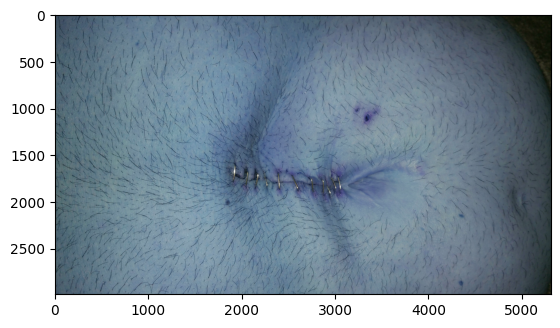

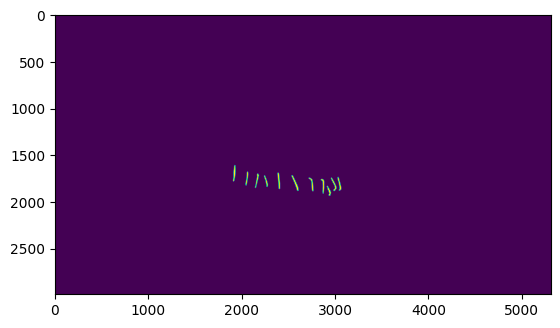

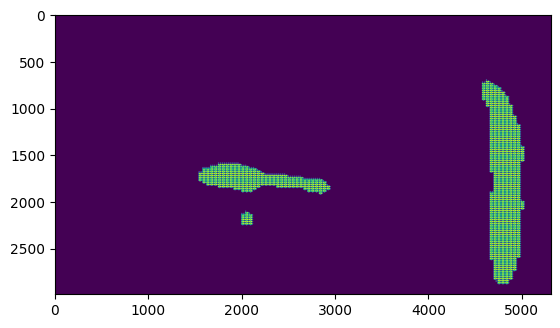

In [22]:
plt.imshow(original_image)
plt.show()

plt.imshow(gt_image)
plt.show()

plt.imshow(prediction)
plt.show()


Ara implementarem dues funcions que reben per paràmetres la gt i la predicció i ens retornen la mètrica: la dice i la jaccard.

In [23]:
 def metriques_absolutes(gt_image, prediction):
    (n,m) = numpy.shape(gt_image)  
    
    if (n,m) != numpy.shape(prediction): # comprovació que les mides de la imatge de la predicció i la de la gt coincideixen
        return []
    
    [tp,fn,fp,tn] = [0,0,0,0] # si les mides coincideixen, calcularem les mètriques absolutes
    for i in range(n):
        for j in range(m):
            if gt_image[i][j]==255 and prediction[i][j]==255: 
                tp += 1
            elif gt_image[i][j]==255 and prediction[i][j]==0:
                fn += 1
            elif gt_image[i][j]==0 and prediction[i][j]==255:
                fp += 1
            elif gt_image[i][j]==0 and prediction[i][j]==0:
                tn += 1
                    
    return [tp,fn,fp,tn]

In [24]:
def dice_coefficient(gt_image, prediction):
    metriques = metriques_absolutes(gt_image, prediction)  
    
    if metriques == []:
        return []
    
    [tp,fn,fp,tn] = metriques
    # calculem el valor del coeficient de dice
    if (2*tp + fp + fn) == 0: #això voldria dir que tots el coefs. són TN i, per tant, ho fa bé
        dice = 1
    else:
        dice = 2*tp/(2*tp + fp + fn)
    
    return [tp,fn,fp,tn,dice]

In [25]:
def jaccard_coefficient(gt_image, prediction):
    metriques = metriques_absolutes(gt_image, prediction)
    
    if metriques == []:
        return []
    
    [tp,fn,fp,tn] = metriques
    # calculem el valor del coeficient de jaccard
    if (tp + fp + fn) == 0: #com abans, la predicció és bona
        jaccard = 1
    else:
        jaccard = tp/(tp + fp + fn)
    
    return [tp,fn,fp,tn,jaccard]

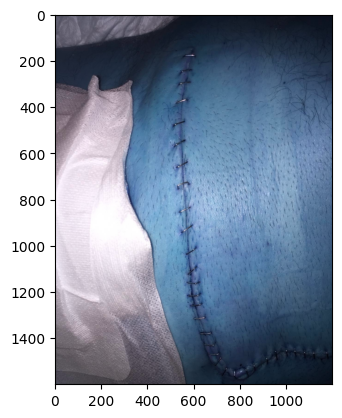

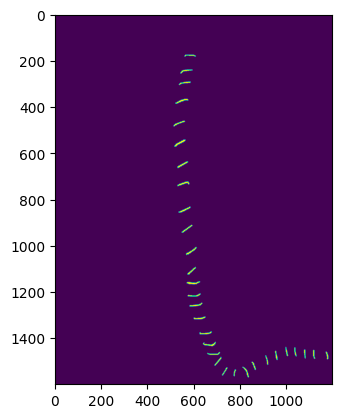

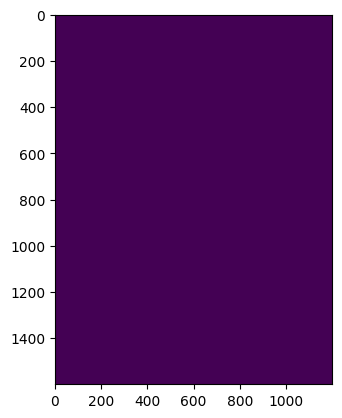

[0, 8771, 0, 1911229, 0.0]


In [26]:
# PROVA SI FUNCIONA LA CALCULADORA DE MÈTRIQUES ABSOLUTES
imatges_train = os.path.join(REDSCAR_DATASET_TRAIN, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TRAIN, "GT_STAPLES_MASK")
    
nom_imatge = '3XOKKCioHUZbjDr5S21pGwHU6_infection=0_capture=1_resolution=1.png' #imatge amb 0s i 1s 

imatge = cv2.imread(os.path.join(imatges_train, nom_imatge), 1) # en color
gt = cv2.imread(os.path.join(gt_train, nom_imatge), 0) # escala de grisos

plt.imshow(imatge)
plt.show()

plt.imshow(gt)
plt.show()
#feim la predicció
#prediccio = predict_image(model=unet, model_input=(256, 256), image=imatge)
prediccio = predict_image(model=loaded_model, model_input=(512, 512), image=imatge)
plt.imshow(prediccio)
plt.show()

print(dice_coefficient(gt, prediccio))

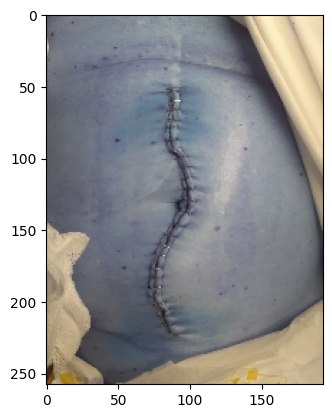

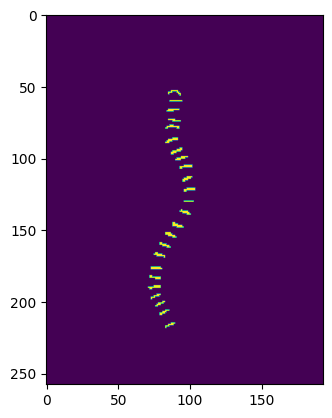

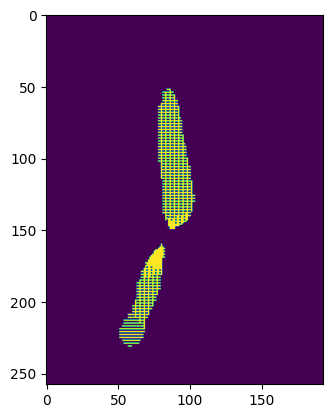

[174, 165, 1604, 47851, 0.1643835616438356]


In [27]:
# PROVA 2 SI FUNCIONA LA CALCULADORA DE MÈTRIQUES ABSOLUTES
imatges_train = os.path.join(REDSCAR_DATASET_TEST, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TEST, "GT_STAPLES_MASK")
    
nom_imatge = 'zU1LXaMl34s64fxf22resmwfs_infection=0_capture=1_resolution=0.png' 

imatge = cv2.imread(os.path.join(imatges_train, nom_imatge), 1) # en color
gt = cv2.imread(os.path.join(gt_train, nom_imatge), 0) # escala de grisos

plt.imshow(imatge)
plt.show()

plt.imshow(gt)
plt.show()
#feim la predicció
#prediccio = predict_image(model=unet, model_input=(256, 256), image=imatge)
prediccio = predict_image(model=loaded_model, model_input=(512, 512), image=imatge)
plt.imshow(prediccio)
plt.show()

print(dice_coefficient(gt, prediccio))

Ara avaluarem les imatges de train amb ambdues mètriques:

In [28]:
noms_imatges = []
dice_imatges = []
jaccard_imatges = []
tp_imatges = []
fn_imatges = []
fp_imatges = []
tn_imatges = []

imatges_train = os.path.join(REDSCAR_DATASET_TRAIN, "IMAGES")
gt_train = os.path.join(REDSCAR_DATASET_TRAIN, "GT_STAPLES_MASK")

for nom_imatge in os.listdir(imatges_train): 
    
    noms_imatges.append(nom_imatge)
    imatge = cv2.imread(os.path.join(imatges_train,nom_imatge), 1) # en color
    gt = cv2.imread(os.path.join(gt_train,nom_imatge), 0) # escala de grisos
    #feim la predicció
    prediccio = predict_image(model=loaded_model, model_input=(512, 512), image=imatge)
    
    #avaluam amb cada mètrica
    dice_resultat = dice_coefficient(gt, prediccio)
    if dice_resultat != []:
        dice = dice_resultat[-1]
        dice_imatges.append(dice)
        jaccard = jaccard_coefficient(gt, prediccio)[-1]
        jaccard_imatges.append(jaccard)
        tp = dice_resultat[0]
        tp_imatges.append(tp)
        fn = dice_resultat[1]
        fn_imatges.append(fn)
        fp = dice_resultat[2]
        fp_imatges.append(fp)
        tn = dice_resultat[3]
        tn_imatges.append(tn)
        
    else:
        dice_imatges.append(None)
        jaccard_imatges.append(None)
        tp_imatges.append(None)
        fp_imatges.append(None)
        fn_imatges.append(None)
        tn_imatges.append(None)
    
import pandas as pd

# cream un DataFrame
erfnet_grapes_train = pd.DataFrame({'NOM': noms_imatges, 'DICE': dice_imatges, 'JACCARD': jaccard_imatges, 'TP': tp_imatges, 'FN': fn_imatges, 'FP': fp_imatges, 'TN': tn_imatges})

# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/erfnet_ma_grapes_train.csv'
erfnet_grapes_train.to_csv(RESULTATS_PATH, index=False)


Farem el mateix amb les imatges de test:

In [29]:
noms_imatges = []
dice_imatges = []
jaccard_imatges = []
tp_imatges = []
fn_imatges = []
fp_imatges = []
tn_imatges = []

imatges_test = os.path.join(REDSCAR_DATASET_TEST, "IMAGES")
gt_test = os.path.join(REDSCAR_DATASET_TEST, "GT_STAPLES_MASK")

for nom_imatge in os.listdir(imatges_test): 
    
    noms_imatges.append(nom_imatge)
    imatge = cv2.imread(os.path.join(imatges_test,nom_imatge), 1) # en color
    gt = cv2.imread(os.path.join(gt_test,nom_imatge), 0) # escala de grisos
    #feim la predicció
    prediccio = predict_image(model=loaded_model, model_input=(512, 512), image=imatge)
    
    #avaluam amb cada mètrica
    dice_resultat = dice_coefficient(gt, prediccio)
    if dice_resultat != []:
        dice = dice_resultat[-1]
        dice_imatges.append(dice)
        jaccard = jaccard_coefficient(gt, prediccio)[-1]
        jaccard_imatges.append(jaccard)
        tp = dice_resultat[0]
        tp_imatges.append(tp)
        fn = dice_resultat[1]
        fn_imatges.append(fn)
        fp = dice_resultat[2]
        fp_imatges.append(fp)
        tn = dice_resultat[3]
        tn_imatges.append(tn)
        
    else:
        dice_imatges.append(None)
        jaccard_imatges.append(None)
        tp_imatges.append(None)
        fp_imatges.append(None)
        fn_imatges.append(None)
        tn_imatges.append(None)
    
import pandas as pd

# cream un DataFrame
erfnet_grapes_test = pd.DataFrame({'NOM': noms_imatges, 'DICE': dice_imatges, 'JACCARD': jaccard_imatges, 'TP': tp_imatges, 'FN': fn_imatges, 'FP': fp_imatges, 'TN': tn_imatges})

# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/erfnet_ma_grapes_test.csv'
erfnet_grapes_test.to_csv(RESULTATS_PATH, index=False)


## Algunes prediccions:
Per a poder veure com de bé ho fa la xarxa ERFNet, guardarem algunes prediccions. En aquest cas, seleccionarem 15 imatges del DS (les 10 millors segons la mètrica dice i les 5 pitjors) i en guardarem a la carpeta 'Resultats' 

Ara implementarem diverses funcions per a obtenir visualitzacions dels resultats

In [6]:
# funció ppal que cridarà a les altres:
def visualitzacions(model, noms_imatges: list, ruta_imatges: str, ruta_gt: str, input_size: int, ruta_guardar: str, titol: str, qualitat: int):
    k = 1 
    for nom in noms_imatges:
        # carregam la imatge, la gt i feim la predicció
        imatge = cv2.imread(os.path.join(ruta_imatges, nom), 1) # en color
        gt = cv2.imread(os.path.join(ruta_gt, nom), 0) # escala de grisos
        prediccio = predict_image(model=loaded_model, model_input=(input_size, input_size), image=imatge)
        
        # cridam a la funció que dibuixa la prediccio sobre la imatge original
        res1 = mascara(imatge,prediccio)
        cv2.imwrite(ruta_guardar+rf"/{titol}_{k}_mascara.png", res1)
        
        # cridam a la funció que dibuixa els contorns de la predicció i de la gt sobre la imatge original
        res2 = contorns(imatge, prediccio, gt, qualitat)
        cv2.imwrite(ruta_guardar+rf"/{titol}_{k}_contorns.png", res2)
        plt.imshow(res2)
        plt.show()
        
        k += 1

In [7]:
# funció auxiliar que dibuixa la predicció sobre la imatge original:
def mascara(imatge, prediccio):
    mascara = imatge.copy()
    for i in range(imatge.shape[0]):
        for j in range(imatge.shape[1]):
            if prediccio[i, j] > 0:  
                mascara[i, j] = [107,183,189]  # Paint in yellow
    return mascara    

In [8]:
# funció auxiliar que dibuixa els contorns de la gt i de la prediccio sobre la imatge original:
# color gt = green; color prediccio = red
def contorns(imatge, prediccio, gt, qualitat):
    resultat = imatge.copy()
    # PREDICCIO
    # find contours with hierarchy
    contours, hier = cv2.findContours(prediccio.astype(numpy.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
                                                # how the contours are retrieved and organized, contour approximation method
    # Define sufficient enough colors for blobs (taques)
    colors = [(0, 255, 0), (0, 0, 255)] # green and red (BGR format)
    k = -1
    for i, cnt in enumerate(contours):
        if (hier[0, i, 3] == -1):  # Check if the current contour has no parent, i.e., the contour is an external contour
            k += 1
        if qualitat == 1:
            cv2.drawContours(resultat, [cnt], -1, colors[1], 5) #pintam la predicció de vermell
        else:
            cv2.drawContours(resultat, [cnt], -1, colors[1], 1) #pintam la predicció de vermell

        
    # GT
    # find contours with hierarchy
    contours, hier = cv2.findContours(gt.astype(numpy.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                                                # how the contours are retrieved and organized, contour approximation method
    k = -1
    for i, cnt in enumerate(contours):
        if (hier[0, i, 3] == -1):  # Check if the current contour has no parent, i.e., the contour is an external contour
            k += 1
        if qualitat == 1:
            cv2.drawContours(resultat, [cnt], -1, colors[0], 5) #pintam la gt de verd
        else:
            cv2.drawContours(resultat, [cnt], -1, colors[0], 1) #pintam la gt de verd
    return resultat

Ara sí, anem a guardar els resultats:

## Filtratge 1: millors i pitjors imatges d'alta resolució

In [10]:
# carregam el data frame de test:
import pandas as pd
df = pd.read_csv('/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/erfnet_ma_grapes_test.csv')

# filtram les imatges d'alta resolució -> df1:
df1 = df[df['NOM'].str.endswith('resolution=1.png')]

# eliminam les que NO tenen cap grapa
noms_sense = ['qfBqdnHgJkPwfL4apJ8o2N4na_infection=0_capture=1_resolution=1.png',
              'KnclSSvSGyJt26zuAelrcgQ6b_infection=0_capture=1_resolution=1.png',
             'djnIcpMtGUmA2PAxIYTDpdD9y_infection=0_capture=1_resolution=1.png',
             'YzLNpYW33lmFgkqNRUKgIzj1J_infection=0_capture=1_resolution=1.png']
df1 = df1[~df1['NOM'].isin(noms_sense)].reset_index(drop=True)

# l'ordenam en funció del coeficient dice
df1_sorted = df1.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar

print(df1_sorted)

                                                  NOM      DICE   JACCARD  \
0   LXQrOdrvDpmyf3mAIX5wN6j1v_infection=0_capture=...  0.175950  0.096461   
1   CTkubOmT4jGHMcyOn9CkdXtGK_infection=0_capture=...  0.174236  0.095432   
2   3R0NltinyMKFc1pWXWYojaUeV_infection=0_capture=...  0.161203  0.087668   
3   iW4S6GSwjAlGEEqslZSdGRcZr_infection=0_capture=...  0.147250  0.079476   
4   OmW5Rka7xqI5ASYPGUzcXQU8m_infection=0_capture=...  0.145101  0.078226   
..                                                ...       ...       ...   
61  AAb0Z0BZMuyDQL1tQLRrCnAwb_infection=1_capture=...  0.000000  0.000000   
62  QH6mgcGbzsncWBu9z8LlgNI7g_infection=0_capture=...  0.000000  0.000000   
63  lQuMfUkoGSM9lYFouStFDqUe6_infection=0_capture=...  0.000000  0.000000   
64  ryKjQSSENOdxC3TMnxV622ENQ_infection=0_capture=...  0.000000  0.000000   
65  RkD87UBnT8JZWcIj3DpAjGGa1_infection=0_capture=...  0.000000  0.000000   

       TP     FN      FP        TN  
0   10566  27332   71638   5705586  
1

In [11]:
nom_tots = []
dice_tots = []

# seleccionam les 10 millors
nom_millors = []
for i in range(10):
    nom = df1_sorted.loc[i,"NOM"]
    nom_millors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(df1_sorted.loc[i,"DICE"])
    
# seleccionam les 5 pitjors
nom_pitjors = []
n = df1_sorted.shape[0]
# iteram a les 5 darreres files
for i in range(n-5,n):
    nom = df1_sorted.loc[i,"NOM"]
    dice_value = df1_sorted.loc[i,"DICE"]
    nom_pitjors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(dice_value)
print(nom_millors)
print(nom_tots) 
print(dice_tots)
resultats_erfnet_alta = pd.DataFrame({'NOM':nom_tots, 'DICE':dice_tots})
# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/erfnet_ma_grapes_resultats_alta.csv'
resultats_erfnet_alta.to_csv(RESULTATS_PATH, index=False)


['LXQrOdrvDpmyf3mAIX5wN6j1v_infection=0_capture=1_resolution=1.png', 'CTkubOmT4jGHMcyOn9CkdXtGK_infection=0_capture=1_resolution=1.png', '3R0NltinyMKFc1pWXWYojaUeV_infection=0_capture=1_resolution=1.png', 'iW4S6GSwjAlGEEqslZSdGRcZr_infection=0_capture=1_resolution=1.png', 'OmW5Rka7xqI5ASYPGUzcXQU8m_infection=0_capture=1_resolution=1.png', 'Klnp8hQnDh2ml8jyP7XNVyd6D_infection=0_capture=1_resolution=1.png', '3UvxqIcSqGcRtnqKiN9CCk2mQ_infection=0_capture=1_resolution=1.png', '1Nt2Dcn2ztA8EIzggVYdBkhTb_infection=0_capture=1_resolution=1.png', 'mYK7RLzwiniuS242ozwJGMnVp_infection=0_capture=1_resolution=1.png', 'XFTnygo35Pqz4remF7QvNtYPs_infection=0_capture=1_resolution=1.png']
['LXQrOdrvDpmyf3mAIX5wN6j1v_infection=0_capture=1_resolution=1.png', 'CTkubOmT4jGHMcyOn9CkdXtGK_infection=0_capture=1_resolution=1.png', '3R0NltinyMKFc1pWXWYojaUeV_infection=0_capture=1_resolution=1.png', 'iW4S6GSwjAlGEEqslZSdGRcZr_infection=0_capture=1_resolution=1.png', 'OmW5Rka7xqI5ASYPGUzcXQU8m_infection=0_capture

2024-07-01 21:44:50.924550: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2024-07-01 21:44:51.713728: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


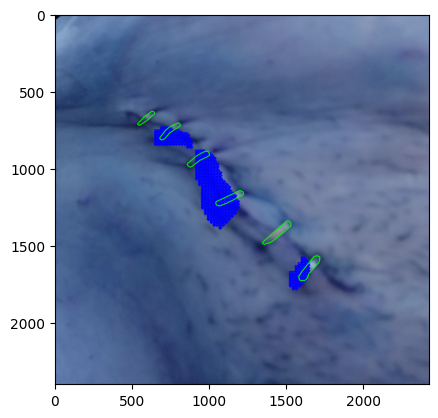

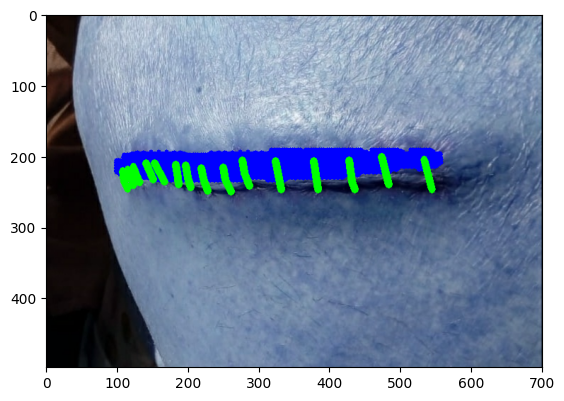

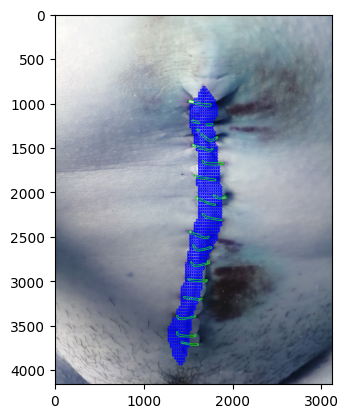

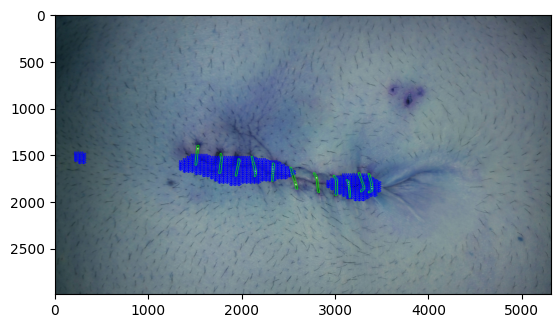

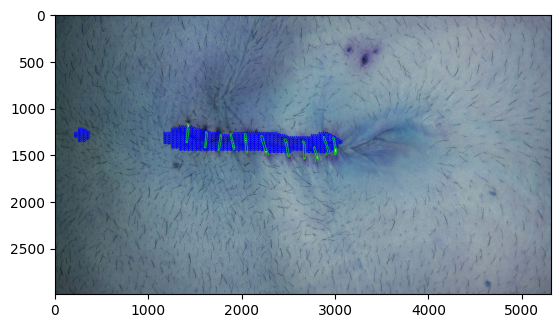

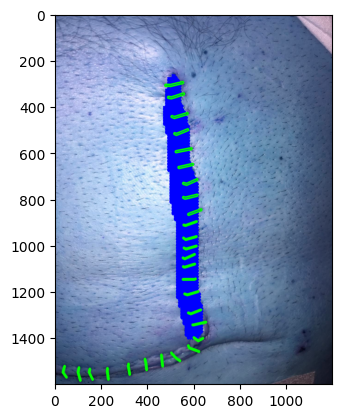

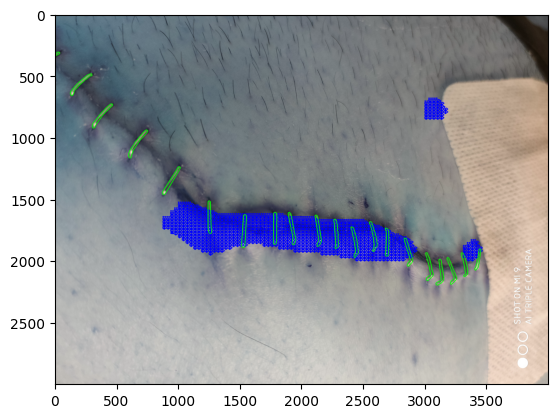

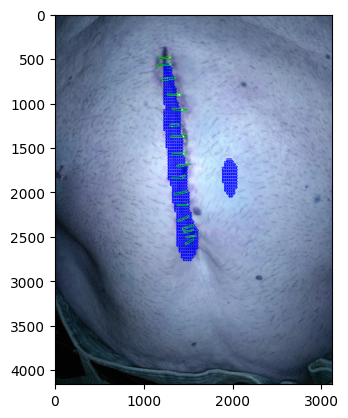

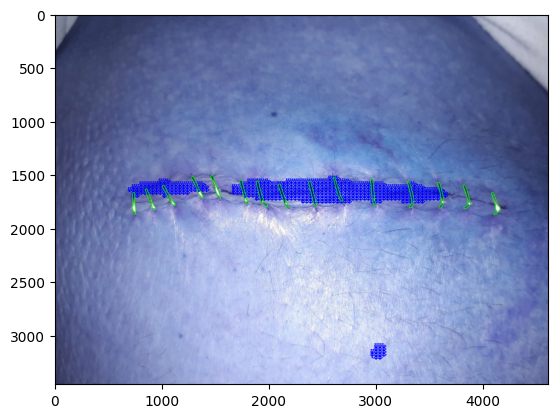

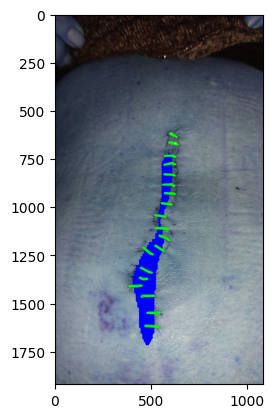

In [12]:
ruta_millors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/alta_resolucio_10_millors'

ruta_imatge = os.path.join(REDSCAR_DATASET_TEST,'IMAGES')
ruta_gts = os.path.join(REDSCAR_DATASET_TEST,'GT_STAPLES_MASK')

# guardam les millors
visualitzacions(model=loaded_model, noms_imatges=nom_millors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=512, ruta_guardar = ruta_millors, titol="millor", qualitat=1)


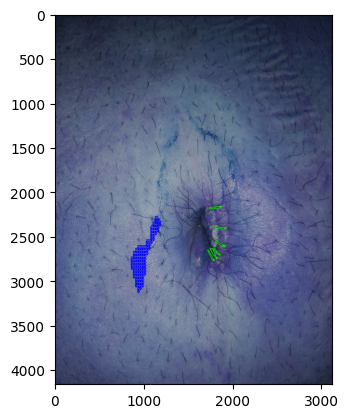

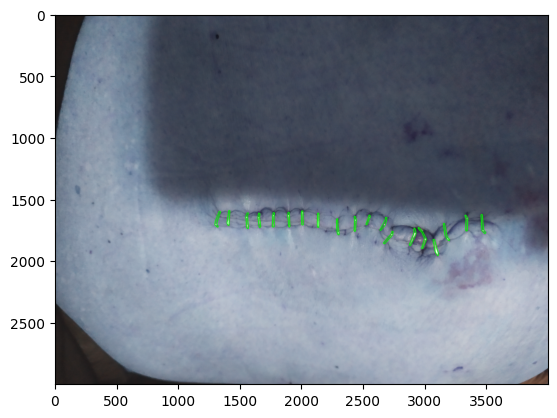

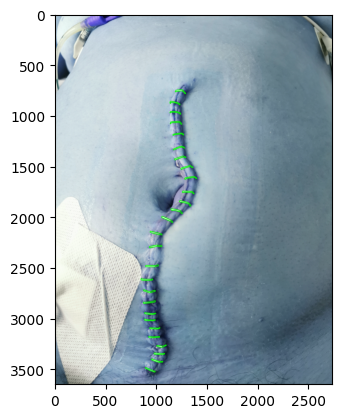

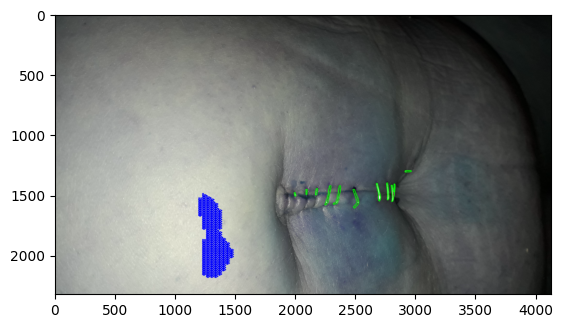

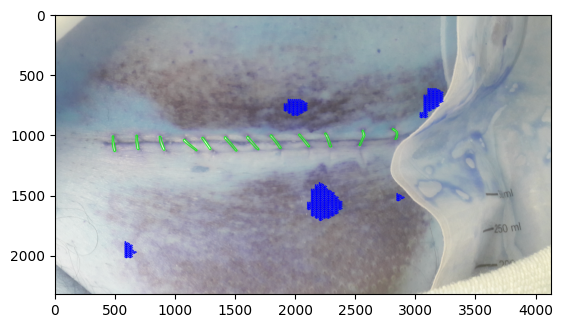

In [13]:
ruta_pitjors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/alta_resolucio_5_pitjors'

# guardam les pitjors
visualitzacions(model=loaded_model, noms_imatges=nom_pitjors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=512, ruta_guardar = ruta_pitjors, titol="pitjor", qualitat=1)


## Filtratge 2: millors i pitjors imatges de baixa resolució

In [15]:
# filtram les imatges d'alta resolució -> df2:
df2 = df[df['NOM'].str.endswith('resolution=0.png')]

# eliminam les que NO tenen cap grapa
noms_sense = ['BSmmQo7gZrySCxbaqbqcUrv2F_infection=0_capture=1_resolution=0.png',
             'fEMdP896R7Ns2a6mtbb0uGbpT_infection=0_capture=1_resolution=0.png',
             'YH30nPmh3tokV3aNsPNrFNtpt_infection=0_capture=1_resolution=0.png',
             'fgXrcZ3JaNWgGsJWrjpt8kTi8_infection=0_capture=1_resolution=0.png',
             '2XKzbg86QY1lzFzF6xyk8r49M_infection=0_capture=1_resolution=0.png']
df2 = df2[~df2['NOM'].isin(noms_sense)].reset_index(drop=True)

# l'ordenam en funció del coeficient dice
df2_sorted = df2.sort_values(by='DICE',ascending=False).reset_index(drop=True)# ordenem el df de major a menor coef. de dice
                                                       # per a accedir més fàcilment a les imatges que volem seleccionar

print(df2_sorted)

                                                  NOM      DICE   JACCARD  \
0   1z5Xfs2sYPUbqsqMfZBy23Aan_infection=0_capture=...  0.305045  0.179972   
1   fsQjP7gdPYnqNWbJACkayeaK8_infection=0_capture=...  0.303030  0.178571   
2   eLAueFsX2uuS8St1LLQo0uAVI_infection=0_capture=...  0.296451  0.174020   
3   FkjbaDe3x5vbXR5g1eAR4jhQM_infection=0_capture=...  0.275862  0.160000   
4   5tTSvHZ1t938soPFQt3iHl9mG_infection=0_capture=...  0.267537  0.154426   
5   tSBNbbT8NVk7wj1KEn5UVHOtU_infection=0_capture=...  0.247339  0.141122   
6   4DW7XoGmJl5dRJv19NByC3bjs_infection=0_capture=...  0.245161  0.139706   
7   XIIlLL72NJGmdAye6jDJ5O9af_infection=0_capture=...  0.214101  0.119884   
8   cPYhmZcbJwrTse9ivAwswH3aR_infection=0_capture=...  0.210037  0.117342   
9   bY4zWtNYXKhaPtnFwqWasgLax_infection=0_capture=...  0.206424  0.115091   
10  Cb0NA3WPBx6vM8escc4Am9S5N_infection=0_capture=...  0.186525  0.102855   
11  qa7ZPHE0R4i2j7kXEPoBONKRG_infection=0_capture=...  0.176678  0.096899   

In [16]:
nom_tots = []
dice_tots = []

# seleccionam les 10 millors
nom_millors = []
for i in range(10):
    nom = df2_sorted.loc[i,"NOM"]
    nom_millors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(df2_sorted.loc[i,"DICE"])
    
# seleccionam les 5 pitjors
nom_pitjors = []
n = df2_sorted.shape[0]
# iteram a les 5 darreres files
for i in range(n-5,n):
    nom = df2_sorted.loc[i,"NOM"]
    dice_value = df2_sorted.loc[i,"DICE"]
    nom_pitjors.append(nom)
    nom_tots.append(nom)
    dice_tots.append(dice_value)
print(nom_millors)
print(nom_tots) 
print(dice_tots)
resultats_erfnet_baixa = pd.DataFrame({'NOM':nom_tots, 'DICE':dice_tots})
# el guardam com un arxiu .csv en la carpeta resultats
RESULTATS_PATH = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/erfnet_ma_grapes_resultats_baixa.csv'
resultats_erfnet_baixa.to_csv(RESULTATS_PATH, index=False)


['1z5Xfs2sYPUbqsqMfZBy23Aan_infection=0_capture=1_resolution=0.png', 'fsQjP7gdPYnqNWbJACkayeaK8_infection=0_capture=1_resolution=0.png', 'eLAueFsX2uuS8St1LLQo0uAVI_infection=0_capture=1_resolution=0.png', 'FkjbaDe3x5vbXR5g1eAR4jhQM_infection=0_capture=1_resolution=0.png', '5tTSvHZ1t938soPFQt3iHl9mG_infection=0_capture=1_resolution=0.png', 'tSBNbbT8NVk7wj1KEn5UVHOtU_infection=0_capture=1_resolution=0.png', '4DW7XoGmJl5dRJv19NByC3bjs_infection=0_capture=1_resolution=0.png', 'XIIlLL72NJGmdAye6jDJ5O9af_infection=0_capture=1_resolution=0.png', 'cPYhmZcbJwrTse9ivAwswH3aR_infection=0_capture=1_resolution=0.png', 'bY4zWtNYXKhaPtnFwqWasgLax_infection=0_capture=1_resolution=0.png']
['1z5Xfs2sYPUbqsqMfZBy23Aan_infection=0_capture=1_resolution=0.png', 'fsQjP7gdPYnqNWbJACkayeaK8_infection=0_capture=1_resolution=0.png', 'eLAueFsX2uuS8St1LLQo0uAVI_infection=0_capture=1_resolution=0.png', 'FkjbaDe3x5vbXR5g1eAR4jhQM_infection=0_capture=1_resolution=0.png', '5tTSvHZ1t938soPFQt3iHl9mG_infection=0_capture

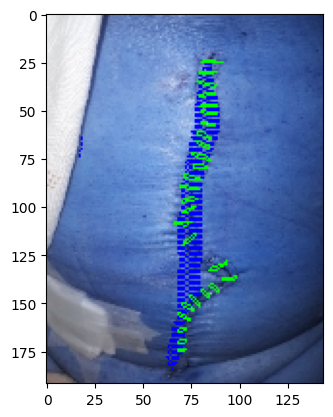

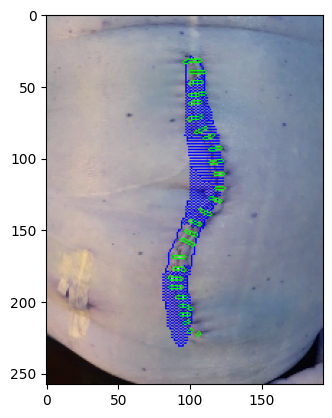

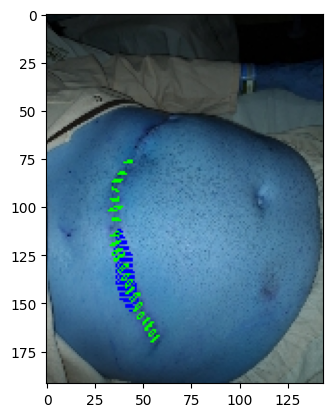

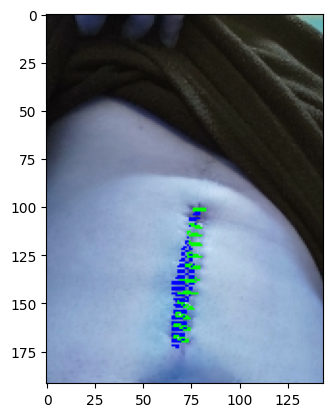

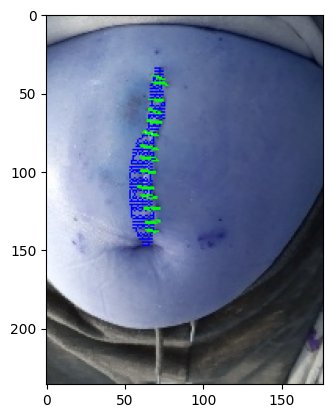

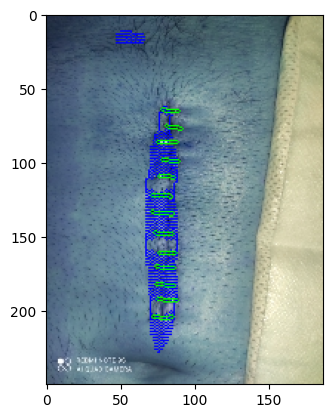

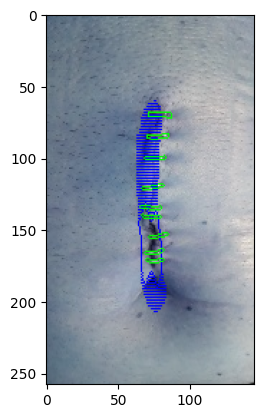

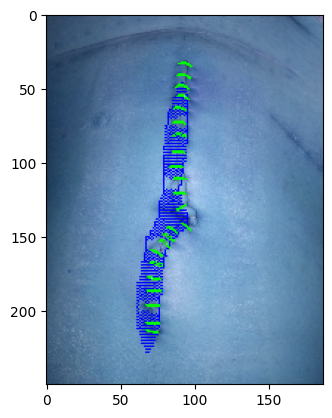

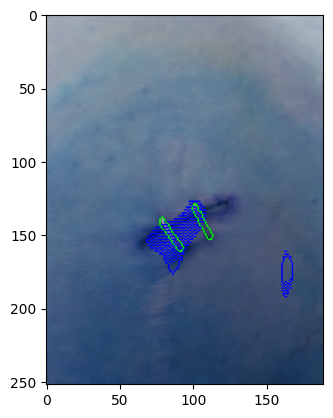

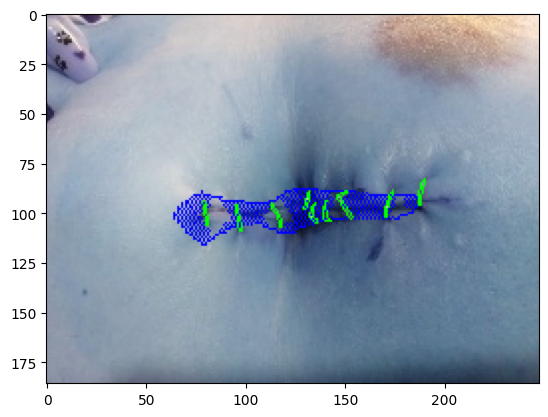

In [17]:
ruta_millors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/baixa_resolucio_10_millors'

# guardam les millors
visualitzacions(model=loaded_model, noms_imatges=nom_millors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=512, ruta_guardar = ruta_millors, titol="millor", qualitat=0)

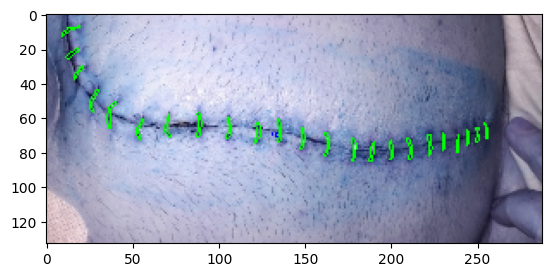

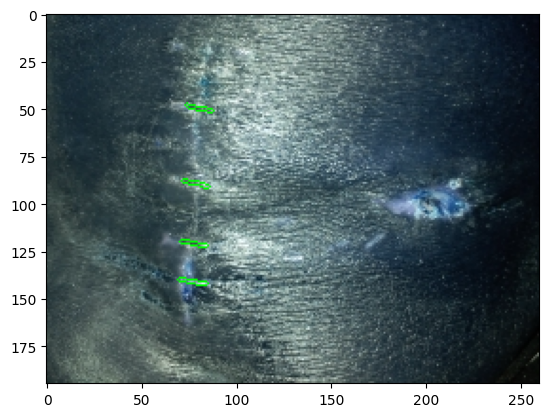

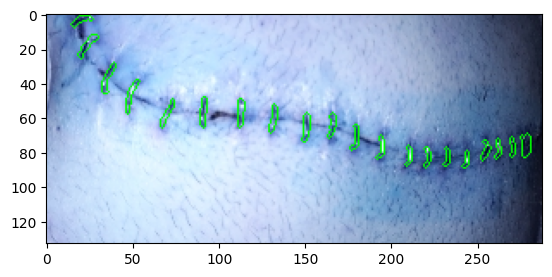

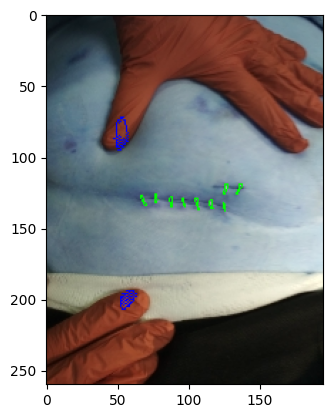

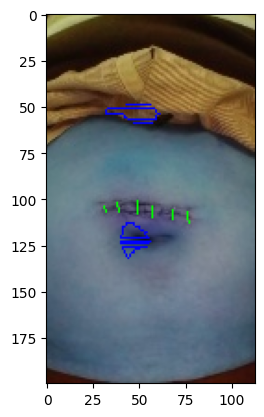

In [18]:
ruta_pitjors = '/home/marc/ANGELS_EXPERIMENTS/Results/Experiment20/baixa_resolucio_5_pitjors'

# guardam les pitjors
visualitzacions(model=loaded_model, noms_imatges=nom_pitjors, ruta_imatges=ruta_imatge, ruta_gt=ruta_gts, input_size=512, ruta_guardar = ruta_pitjors, titol="pitjor", qualitat=0)